# Analytical Grid

$$\DeclareMathOperator{\sech}{sech}$$

- $h_J$: depth of the reef pass, also the depth of the lagoon
- $h_f$: depth of the reef flat
- $h_r$: depth of the reef crest

Compose the following functions to create the inshore bathymetry $h_i(\xi,\eta)$

$$ h_{\text{lagoon}} = \frac{(h_J - h_f)}{2}\big[1 + \tanh{\alpha_l \eta} \big] $$  
$$ h_{\text{reef flat}} = (h_f - h_r)\big[ 1 - \sech{\alpha_f \eta^2} \big] - h_r $$

where $\alpha_?$ are tuning parameters, as follows

$$ h_i = h_{\text{lagoon}} + h_{\text{reef flat}} $$

The transition from the reef crest to the forereef must be done carefully to avoid issues at the corners of the reef pass. 

$$h_i(\eta>L_r) = (h_J - h_r)\big[ 1 - \sech{\alpha_r x^2} \big] - h_r $$

A symmetric two-sided tapering function, $\tau_{\xi}$, is applied to control the width of the reef pass

$$ h_i = (1-\tau_{\xi}) h_J +  \tau_{\xi}h_i $$

where

$$\tau_{\xi} = \sech{\alpha_J \xi^4}$$

The forereef slope bathymetry is linear $h_o$ 

$$h_o(\eta) = h_J + \Lambda(\eta-L_r)$$

which transitions from the lagoon bathymetry using another tapering function $\tau_{\eta}$ as follows

$$ h(\xi,\eta) = h_i(1-\tau_{\eta}) + h_0\tau_\eta $$

where 

$$\tau_{\eta} = \frac{1}{2}\big[1  + \tanh{\alpha_{\eta}\xi} \big] $$

### Grid refinement

Grid points are distributed non-uniformly along ($\xi,\eta$) coordinates to achieve higher resolution at the reef crest and reef pass using the density function 

$$ \rho = \sech{ \frac{\zeta - \zeta_0}{\sigma} } $$

where $\zeta$ is the initial coordinate normalized and evenly spaced within the range $[0,1]$, $x_0$ is the location parameter, and $\sigma$ is the shape parameter. Following the procedure used by Zhao & Tsiotras (2009), a stretched coordinate ($\zeta'$) adhering to the density distribution ($\rho$) was obtained by evaluating the inverse cumulative distribution function (CDF) of $\rho$ on $\zeta$. The CDF of $\rho$ ($F(\zeta)$) can be found via numerical integration $F = \int^1_0 \rho(\zeta) \, d\zeta$ . $F$ is monotonic and continous and thus invertible. The result of the inversion is  the transformed coordinate $\zeta' = F^{-1}(\zeta)$ which is distributed according to $\rho$. $F^{-1}$ should be first normalized to the range $[0,1]$ then approximated by a spline interpolant ($\mathcal{F}$) and evaluated at the initial evenly spaced coordinate $\zeta$ to produce $\zeta'$. 
$$\mathcal{F}(\zeta) = \zeta'$$

In [17]:
import os
import sys
import subprocess
from dataclasses import dataclass

import numpy as np
import scipy.io as sio
from scipy.optimize import fsolve

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean
import seaborn as sns
from scipy.special import owens_t, erf, logit
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d

import xarray as xr

home = os.environ['HOME']
romspath = f"{home}/Dropbox/Oceanography/code/romspy"
sys.path.insert(0, romspath )
from romspy.grid import s2z, cart2polar, rx0, rx1
from romspy.general import coriolis

mpl.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

In [33]:
@dataclass
class reefGrid():
    hj: float = 20 # depth of the jet"
    hf: float = 2 # depth of the reef flat
    hr: float = 0.5 # depth of the reef crest
    Lr: float = 1/5 # cross-shore distance of reef crest from shore (domain fraction 0-1)
    Ll: float = 1/12 # cross-shore distance of reef flat from shore (domain fraction 0-1)
    Wr: float = np.pi/6 #width of reef (radians)
    N_xi: int = 172 # grid cells in xi direction
    N_eta: int = 256 # grid cells in eta direction
    
    def __post_init__(self):
        self.zeta_xi = np.linspace(0,1,self.N_xi)
        self.zeta_eta = np.linspace(0,1,self.N_eta)
        self.xi, self.eta = np.meshgrid(self.zeta_xi,self.zeta_eta)
        
    def mesh(self, zeta_xi, zeta_eta):
        self.xi, self.eta = np.meshgrid(self.zeta_xi, self.zeta_eta)
    
    def sech_pdf(self, x, x0 = 0, s = 1):
        return 1/np.cosh( (x - x0)/s )
    
    def wag_pdf(self, x, x0 = 0, s = 1):
        return 1/(1 + s*(x - x0)**2)
    
    def coord_stretch(self, coord, s = 1, x0 = 0.2, function = "sech"):
        """normalized clustering of pts around x0. Input "xi" or "eta" """
        #https://www3.nd.edu/~gtryggva/CFD-Course2017/Lecture-17-2017.pdf
        x = getattr(self, coord)
        if function == "sech":
            rho = self.sech_pdf(x, x0 = x0, s = s)
        elif function == "wag":
            rho = self.wag_pdf(x, x0 = x0, s = s)
        cdf = cumulative_trapezoid(rho, x, initial = 0)
        cdf = (cdf - cdf.min())/(cdf.max() - cdf.min())
        F_inv = interp1d( cdf, x )
        xs = F_inv(x)
        setattr( self, coord, xs )
        return xs

    def export_matfile(self, grdname = "analytic"):
        """generate .mat file for COAWST mfiles to convert to .nc"""
        self.grdname = grdname
        self.mask =  G.h*0+1
        rho = {"x": self.X, "y": self.Y, "depth": self.h, "mask": mask} 
        sio.savemat(f"{grdname}.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})
    
    def swan_halo(self, repeat = 2, sides = ["east", "west"], direction = "azimuthal", axis = 1):
        """repeat domain on given sides (repeat) times"""
        
        #Repeat coords
        
        tlist = np.split(self.T, 2, axis = axis)
        self.T_swan = np.concatenate( (tlist[1] - self.Wr, self.T, tlist[0] + self.Wr),
                                      axis = axis)
        
        rlist = np.split(self.R, 2, axis = axis)
        self.R_swan = np.concatenate((rlist[0] , self.R, rlist[1]),
                                      axis = axis)
        
        #Repeat bathymetry
        hlist = np.split(self.h, 2, axis = axis)
        self.h_swan = np.concatenate( (np.flip(hlist[0],axis = axis), self.h, np.flip(hlist[1],axis = axis) ), #np.flip(hlist[0],axis = axis)
                                      axis = axis)
        #Add mask
        self.mask_swan = self.h_swan*0 + 1
        
        #New cartesian coordinates
        self.X_swan, self.Y_swan = self.R_swan*np.cos(self.T_swan), self.R_swan*np.sin(self.T_swan)
        
    def matfile2roms(self):
        eng = matlab.engine.start_matlab()
        eng.cd(os.getcwd(),nargout=0)
        eng.mat2roms_mw(f"{self.grdname}.mat", f"roms_grid.nc", nargout=0)
        # eng.roms2swan( f"roms_grid.nc", nargout=0 )
        eng.roms2swan( matlab.double(self.X.tolist()), 
                       matlab.double(self.Y.tolist()), 
                       matlab.double(self.h.tolist()), 
                       matlab.double(self.mask.tolist()),nargout = 0 )
        eng.quit()

In [34]:
%matplotlib widget
G = reefGrid(N_xi = 128+2, N_eta = 256+2)
G.coord_stretch("zeta_eta", x0 = 1/5, s = 30, function = "wag")
G.coord_stretch("zeta_xi", x0 = 0.5, s = .2, function = "sech")
G.mesh(G.zeta_xi, G.zeta_eta)

# fig, ax = plt.subplots(figsize = (3,2))
# ax.plot(G.zeta_eta, np.gradient(G.zeta_eta),"k")
# #ax.scatter(G.zeta_eta[::10], G.zeta_eta[::10]*0, s = 0.1,  color = "k")
# #ax.axvline(0.2, color = "k")
# fig.tight_layout()
# fig.show()
# assert False

#Smoothing coefficients
al = 25*np.pi # lagoon -> reef flat
aff = 10000*np.pi # reef flat -> reef crest
afr = 500*np.pi # reef crest-> forereef
ae = 150*np.pi # inshore -> offshore transition
aj = 50000*np.pi # reef channel sides

h_lagoon = (1/2)*(G.hj - G.hf)*(1 - np.tanh(al*(G.eta - G.Ll))) 
h_flat = (G.hf - G.hr)*(1 - 1/np.cosh(aff*(G.eta - G.Lr)**2)) + G.hr
h_fr = (G.hj - G.hr)*(1 - 1/np.cosh(afr*(G.eta - G.Lr)**2)) + G.hr

h_i = h_lagoon + h_flat
h_i = np.where(G.eta < G.Lr, h_i, h_fr)

taper_xi = 1 - 1/np.cosh(aj*(G.xi - 0.5)**4) 
h_i = (1 - taper_xi)*G.hj + taper_xi*(h_i)

h_o = G.hj + (0.1*10e3)/(1 - G.Lr)*(G.eta - G.Lr)
h_o = np.where(G.eta > G.Lr, h_o, 20)

taper_eta = 1/2*(1+np.tanh(ae*(G.eta - G.Lr - 0.005)))
h = h_i*(1 - taper_eta) + taper_eta*h_o

setattr(G,"h",h)

/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/3399471718.py:23: RuntimeWarning: overflow encountered in cosh
  h_flat = (G.hf - G.hr)*(1 - 1/np.cosh(aff*(G.eta - G.Lr)**2)) + G.hr
/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/3399471718.py:24: RuntimeWarning: overflow encountered in cosh
  h_fr = (G.hj - G.hr)*(1 - 1/np.cosh(afr*(G.eta - G.Lr)**2)) + G.hr
/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/3399471718.py:29: RuntimeWarning: overflow encountered in cosh
  taper_xi = 1 - 1/np.cosh(aj*(G.xi - 0.5)**4)


/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/4006690094.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(x/1e3, y/1e3, G.h, cmap = "cmo.ice_r", shading = "auto", norm = LogNorm());


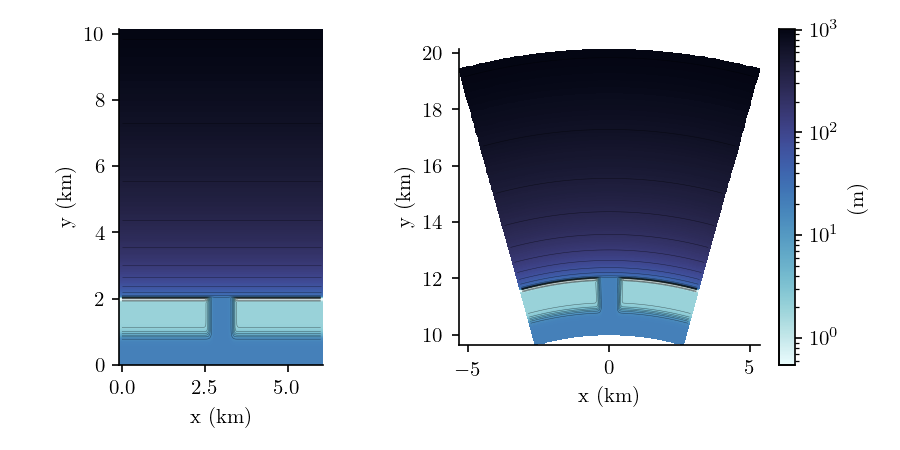

In [35]:
%matplotlib widget

#Cartesian
Lx, Ly = 6e3, 10e3
X,Y = Lx*G.xi, Ly*G.eta

#Polar
R = Ly*G.eta + 10e3
T = np.pi/6*(G.xi - 0.5) + np.pi/2
Xp,Yp = R*np.cos(T), R*np.sin(T)
S = R*(T - np.pi/2)

setattr(G,"X",X)
setattr(G,"Y",Y)
setattr(G,"R",R)
setattr(G,"T",T)
setattr(G,"S",S)

G.swan_halo()

fig, axes = plt.subplots(1, 2, figsize=(6,3))
levels = np.logspace(-1, 3, 25)
for (ax,x,y) in zip(axes,(X,Xp),(Y,Yp)):

    #pc = ax.pcolormesh(x/1e3, y/1e3, taper_eta, cmap = "cmo.ice_r", shading = "auto"); 
    pc = ax.pcolormesh(x/1e3, y/1e3, G.h, cmap = "cmo.ice_r", shading = "auto", norm = LogNorm()); 
    cs = ax.contour(x/1e3, y/1e3, G.h, levels  = levels, colors = "k", linewidths = 0.25, alpha = 0.5);
    
    #ax.clabel(cs, cs.levels, inline=True, fmt = '%d', fontsize=4)
    
    ax.set_aspect("equal")
    ax.set_xlabel(r"x (km)");
    ax.set_ylabel(r"y (km)");

fig.colorbar(pc, ax = ax, orientation = "vertical", label = "(m)")
sns.despine()
fig.tight_layout()



/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/2758536047.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(G.X_swan, G.Y_swan, G.h_swan, cmap = "cmo.ice_r", shading = "auto", norm = LogNorm());


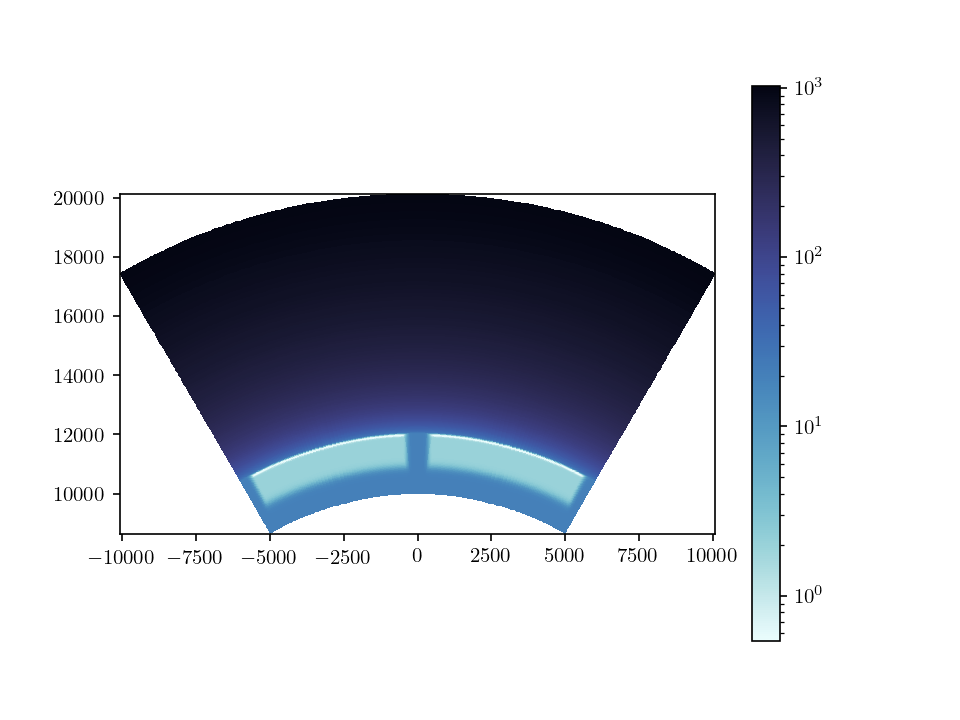

In [36]:
%matplotlib widget
#G.X_swan.shape
plt.pcolormesh(G.X_swan, G.Y_swan, G.h_swan, cmap = "cmo.ice_r", shading = "auto", norm = LogNorm()); 
#plt.pcolormesh(G.T_swan, cmap = "twilight", shading = "auto");
#plt.pcolormesh(G.R_swan, cmap = "Blues", shading = "auto");
#plt.pcolormesh(G.h_swan, cmap = "Blues", shading = "auto", norm = LogNorm());
plt.colorbar()
plt.gca().set_aspect("equal")
#display(G.h_swan.shape)
#G.h_swan[:,-1]

In [37]:
display(f"min d_r = { abs(np.diff(G.R, axis = 0)).min() }")
display(f"max d_r = { abs(np.diff(G.R, axis = 0)).max() }")
display(f"min d_s = { abs(np.diff(G.S, axis = 1)).min() }")
display(f"max d_s = { abs(np.diff(G.S, axis = 1)).max() }")

'min d_r = 15.469617676115377'

'max d_r = 301.23379242313604'

'min d_s = 22.847377069727948'

'max d_s = 262.8620867839754'

## 3D Grid & Plotting

In [38]:
#Compute 3D grid and stiffness metrics

z = s2z(h, ns = 20, thetaS = 3.0, thetaB = 2.0, hc  = 20) #thermocline deep as channel
stiffness = rx1(z)
beckhaid = rx0(h)
display(f"min depth = {h.min()}")
display(f"max depth = {h.max()}")

Maximum rx1-value = 18.28099021754761
Maximum rx0-value = 0.49259741855336037


'min depth = 0.5421013679660056'

'max depth = 1020.0'

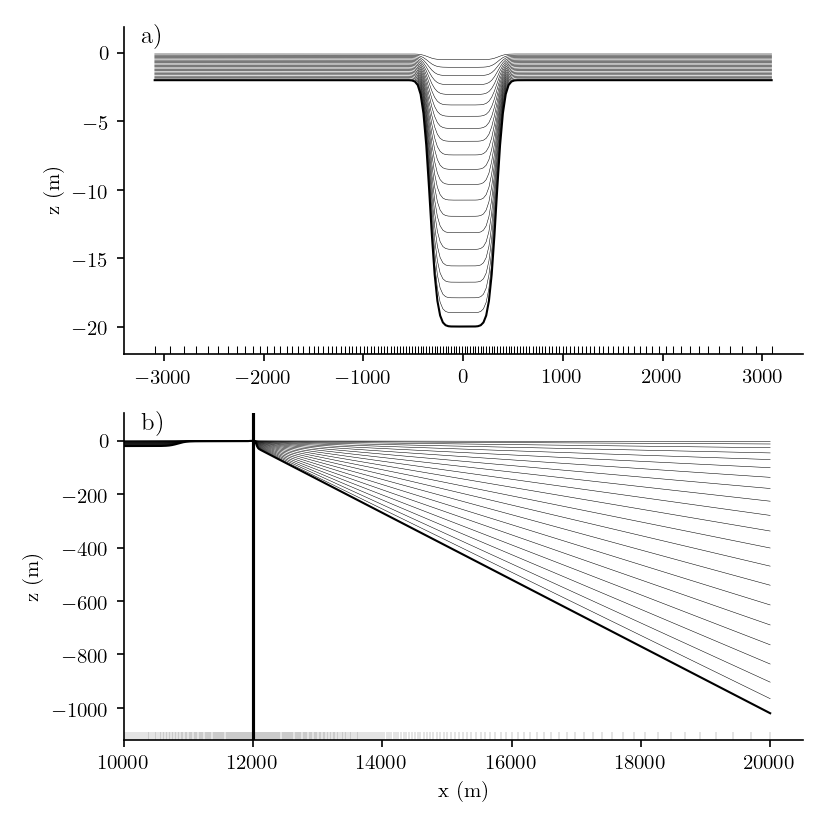

In [39]:
%matplotlib widget
import matplotlib.gridspec as gridspec

i = 0 #86 for centerline
j = 86

#radial, azimut = G.Y[j,:], G.X[:,i]
radial, azimut = G.R[:,i], G.S[j,:]

fig = plt.figure(figsize=(5.5,5.5), dpi = 150)
gs = gridspec.GridSpec(nrows = 2, ncols=1)

ax = fig.add_subplot(gs[0,0])
plt.plot(azimut, z[j,:], color = "k", linewidth = 0.25)
plt.gca().text(0.025, 0.95, "a)", fontsize = 12, transform=plt.gca().transAxes)

plt.plot(azimut, -G.h[j,:], color = "k", linewidth = 1)

sns.rugplot(x = azimut, color = "k", linewidth = 0.5, alpha = 1.0)
#plt.gca().set_xlim(-1e3, 1e3)
plt.gca().set_ylabel("z (m)")

# ax.axes.axvline(-250, color = "k"); ax.axes.axvline( 250, color = "k")

ax = fig.add_subplot(gs[1,0])

plt.plot(radial, z[:,i], color = "k", linewidth = 0.25)
plt.plot(radial, -G.h[:,i], color = "k", linewidth = 1)
sns.rugplot(x = radial, color = "k", linewidth = 0.1)
#plt.gca().set_xlim(11e3,13e3); plt.gca().set_ylim(-5,0)
plt.gca().set_xlim(10e3, None)

# plt.gca().set_xlim(11.5e3, 12.5e3)
#plt.gca().set_ylim(-20,0)
ax.axes.axvline(12000, color = "k")

plt.gca().set_ylabel("z (m)")
plt.gca().text(0.025, 0.95, "b)", fontsize = 12, transform = plt.gca().transAxes)

# fig.add_subplot(gs[:,1])
# plt.pcolormesh(G.X/1e3, G.Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e3), cmap = cmocean.cm.ice_r, shading = "auto" )
# plt.gca().text(0.025, 0.95, "c)", fontsize = 12, transform=plt.gca().transAxes)

plt.gca().set_xlabel("x (m)")
# plt.gca().set_ylabel("y (km)")
# plt.gca().axis("equal")

plt.tight_layout()
sns.despine()

Figure ?: Cross-shore (a) and alongshore (b) cross-sections of the bathymetry. Notice the irregular spacing functions employed to better resolve reef crest and jet processes. The stretching function used is 

$$ x = L\zeta + a(x_0 - L\zeta)(1 - \zeta)\zeta $$

where $\zeta$ is the normalized coordinate (0-1), $L$ is the length of the domain the given direction, and $a$ is a tuning parameter determining the intensity of grid stretching/expansion about $x_0$.

/var/folders/k7/t94g1m4n5nb262lgss92lslm0000gn/T/ipykernel_54540/2250826269.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X/1e3, Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e2), cmap = cmocean.cm.ice_r, shading = "auto" )


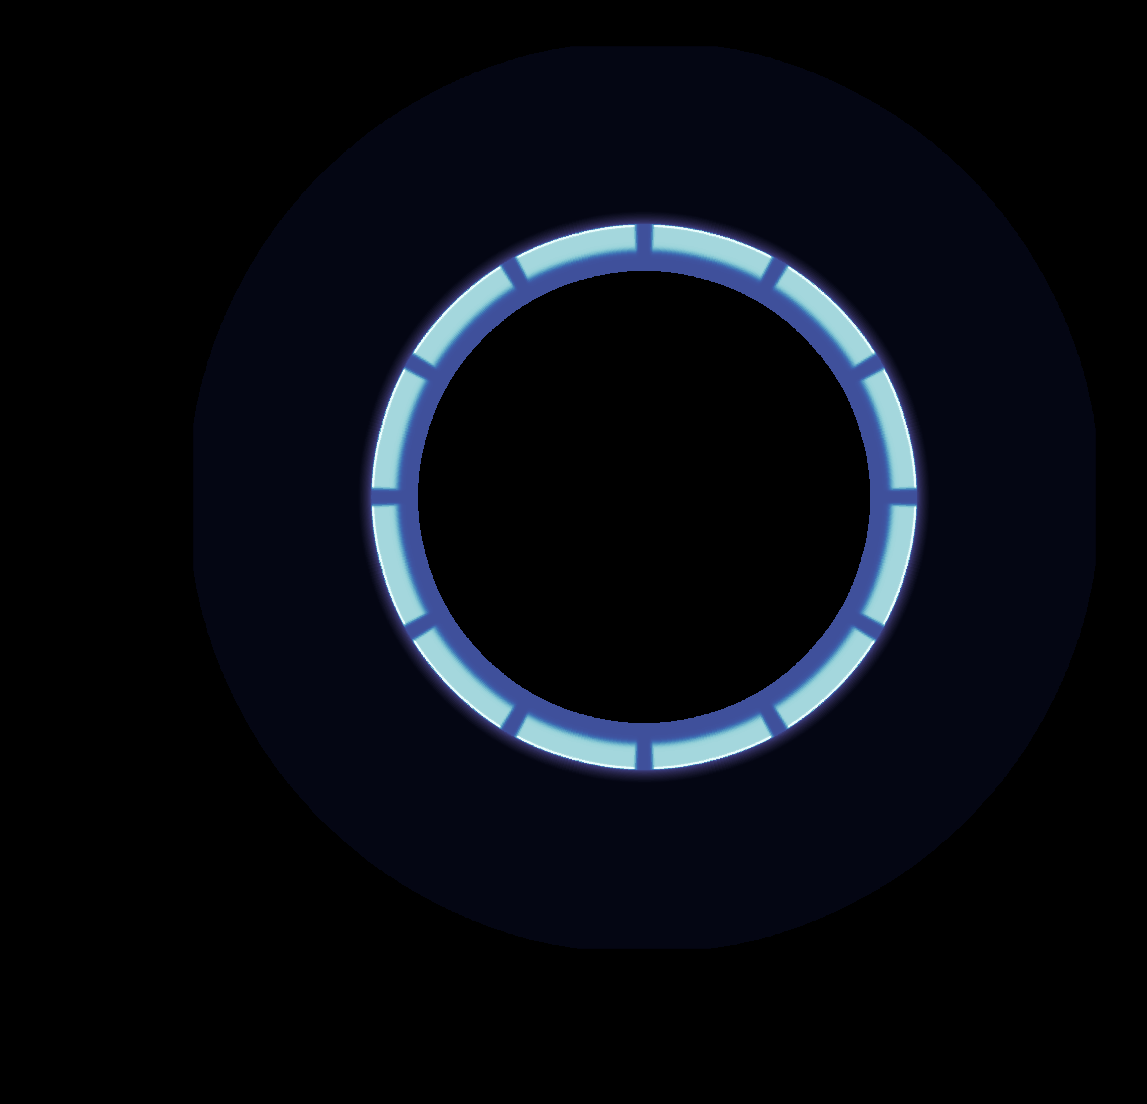

In [ ]:
%matplotlib inline
#Pcolormesh 

fig, ax = plt.subplots(facecolor = "k", dpi = 300)
for k in range(12):
    
    T = G.T+k*np.pi/6
    X,Y = G.R*np.cos(T), G.R*np.sin(T)
    ax.pcolormesh(X/1e3, Y/1e3, G.h, norm = LogNorm(vmin = 1, vmax = 1e2), cmap = cmocean.cm.ice_r, shading = "auto" )

#ax.text(0.025, 0.95, "c)", fontsize = 12, transform=plt.gca().transAxes)
ax.set_facecolor("k")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")

ax.set_xlim(-20,20)
ax.set_ylim(-20,20);
ax.set_aspect("equal")
#fig.savefig("ann_bathy_dark.png")

## Export Grid Files

In [41]:
#Generate .mat file for COAWST mfiles to convert to .nc
grdname = ""

# lon, lat = cart2polar(X,Y)
# rho = {"lon": lon, "lat": lat, "depth": h, "mask": h*0+1}
G.projection = "stereographic"
G.spherical = "F"

mask =  G.h*0+1
rho = {"x": G.X.T, "y": G.Y.T, "depth": G.h.T, "mask": mask.T} 
sio.savemat(f"roms_grid.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})

rho = {"x": G.X_swan.T, "y": G.Y_swan.T, "depth": G.h_swan.T, "mask": G.mask_swan.T} 
sio.savemat(f"swan_grid.mat", {"rho": rho, "spherical": G.spherical, "projection": G.projection})

In [47]:
#impose -fplane if necessary...

#xarray
ds = xr.load_dataset("roms_grid.nc")
ds["f"] = ds.f*0+coriolis(-30)
ds.to_netcdf("roms_grid.nc")

#NCO way
# string = fr'''ncap2 -s "f=f*0+{coriolis(-30)};" -O roms_grid.nc roms_grid.nc'''
# sp = subprocess.run(string, shell = True, check = True)